In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We define the needed libraries here

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time
from scipy.special import xlogy
from keras.datasets import cifar10
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

Load all the data here

In [19]:
def calc_cov(data_set, mean):
    res = np.zeros([data_set.shape[1],data_set.shape[1]])
    for i in range(data_set.shape[0]):
        vect = np.subtract(data_set[i], mean)
        vect = np.array([vect])
        res += np.matmul(vect.T, vect)

    return res/(data_set.shape[0]-1)

def relu(x):
  return np.maximum(x, np.zeros_like(x))

def Cal_accuracy(True_label, Estimated_label):
  return np.count_nonzero(np.transpose(True_label)==np.array(Estimated_label))/True_label.size

def step(x):
  return 1*(x > np.zeros_like(x))

def encode(vect, idx, landa):
  temp = np.multiply(step(landa - vect),-1)
  temp[idx] = 1
  return temp

def gelu(x):
    return 0.5 * np.multiply(x, 1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def Dgelu(x):
  return np.divide(0.053516 * np.power(x, 3) + np.multiply(0.398942, x) , np.power(np.cosh(0.0356774 * np.power(x, 3) +np.multiply(0.79788, x)),2)) + 0.5 * ( 1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def RBF_encode(data, number_class, dim):
  data = np.reshape(data, (dim,int(data.size/dim)), order='F')
  data = LA.norm(data,1, axis = 0)
  data = np.reshape(data, (number_class, int(data.size/number_class)), order='F')
  return data

def expand(x):
  temp = []
  for i in range(len(x)):
    temp.append(x[i])
    temp.append(x[i])
  return temp



In [20]:
def preprocess(apply_PCA):

    (train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

    train_data = np.sum(train_data, axis=3)/3
    test_data = np.sum(test_data, axis=3)/3

    train_data = train_data.reshape(-1, 32*32).astype('float32') / 255
    test_data = test_data.reshape(-1, 32*32).astype('float32') / 255


    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=1)
    
    if apply_PCA:
      Data_avg = np.mean(train_data, axis = 0)
      Data_cov = calc_cov(train_data, Data_avg)
      EigenValues, EigenVectors = LA.eigh(Data_cov) 
      New_EigenValues = EigenValues[-128:]
      New_EigenVectors = EigenVectors[:,-128:]
      train_data = np.matmul(train_data, New_EigenVectors)
      test_data = np.matmul(test_data, New_EigenVectors)
      val_data = np.matmul(val_data, New_EigenVectors)

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [21]:
data = preprocess(False)

In [22]:
Train_data, Train_label, Val_data, Val_label, Test_data, Test_label = data

Here we define the class network

In [23]:
class Network:
  def __init__(self, input_node, hidden_layer, hidden_node, output_node):
    self.number_input_node = input_node
    self.number_hidden_layer = hidden_layer
    self.number_hidden_node = hidden_node
    self.number_class_output = output_node
    self.distance_dim = 2
    self.weight = {}
    self.layer = {}
    self.batch_data = {}
    self.batch_label = {}
    self.diff_weight = {}
    self.score = []
    self.result = []
    self.init_weight()
    self.loss = []
    self.back_prob_output = []
    for i in range(self.number_hidden_layer + 1):
      self.diff_weight["w" + str(i) + "_prev"] = 0
      self.diff_weight["b" + str(i) + "_prev"] = 0
    self.momentum = 0.9
    self.learning_rate = 0.001
    self.number_turn = 100
    self.batchS = 128
    self.accuracy_graph = []
    self.loss_graph = []
    self.landa = 550
    self.accuracy_graph_epoch = []

  def set_turn(self, x):
    self.number_turn = x

  def set_learning_rate(self, x):
    self.learning_rate = x

  def set_batch_size(self, x):
    self.batchS = x
  
  def load_weights(self):
    for i in range(self.number_hidden_layer + 1):
      self.weight["w" + str(i)] = (pd.read_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/w" + str(i) + ".csv", header=None)).to_numpy()
      self.weight["b" + str(i)] = (pd.read_csv("/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/Fashion-MNIST/b" + str(i) + ".csv", header=None)).to_numpy()

  def init_weight(self):
    self.weight["w0"] = np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[0], self.number_input_node))
    self.weight["b0"] = np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[0], 1))

    # self.weight["w0"] = np.zeros((self.number_hidden_node[0], self.number_input_node))
    # self.weight["b0"] = np.zeros((self.number_hidden_node[0], 1))

    for i in range(self.number_hidden_layer - 1):
      # self.weight["w" + str(i+1)] = (np.zeros((self.number_hidden_node[i+1], self.number_hidden_node[i])))
      # self.weight["b" + str(i+1)] = (np.zeros((self.number_hidden_node[i+1], 1)))

      self.weight["w" + str(i+1)] = (np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[i+1], self.number_hidden_node[i])))
      self.weight["b" + str(i+1)] = (np.random.normal(loc=0, scale=0.14, size=(self.number_hidden_node[i+1], 1)))

    # self.weight["w" + str(self.number_hidden_layer)] = np.zeros((self.number_class_output * self.distance_dim, self.number_hidden_node[self.number_hidden_layer-1]))
    # self.weight["b" + str(self.number_hidden_layer)] = np.zeros((self.number_class_output * self.distance_dim, 1))

    self.weight["w" + str(self.number_hidden_layer)] = np.random.normal(loc=0, scale=0.14, size=(self.number_class_output * self.distance_dim, self.number_hidden_node[self.number_hidden_layer-1]))
    self.weight["b" + str(self.number_hidden_layer)] = np.random.normal(loc=0, scale=0.14, size=(self.number_class_output * self.distance_dim, 1))
    
  def forward(self, data):
    self.layer.clear()
    self.layer["input"] = data
    if len(data) == data.size:
      self.layer["z0"] = (np.matmul(self.weight["w0"],np.transpose(data))).reshape((len(MyNetwork.weight["w0"]),1))
    else:
      self.layer["z0"] = (np.matmul(self.weight["w0"], np.transpose(data)))
    self.layer["z0"] = np.add(self.layer["z0"], self.weight["b0"])
    self.layer["r0"] = gelu(self.layer["z0"])
    self.layer["s0"] = Dgelu(self.layer["z0"])
    for i in range(self.number_hidden_layer - 1):
      self.layer["z" + str(i + 1)] = np.matmul(self.weight["w" + str(i + 1)], self.layer["r" + str(i)])
      self.layer["z" + str(i + 1)] = np.add(self.layer["z" + str(i + 1)], self.weight["b" + str(i + 1)])
      self.layer["r" + str(i + 1)] = gelu(self.layer["z" + str(i + 1)])
      self.layer["s" + str(i + 1)] = Dgelu(self.layer["z" + str(i + 1)])
    self.layer["z" + str(self.number_hidden_layer)] = np.matmul(self.weight["w" + str(self.number_hidden_layer)], self.layer["r" + str(self.number_hidden_layer - 1)])
    self.layer["z" + str(self.number_hidden_layer)] = np.add(self.layer["z" + str(self.number_hidden_layer)], self.weight["b" + str(self.number_hidden_layer)])
    self.layer["r" + str(self.number_hidden_layer)] = RBF_encode(self.layer["z" + str(self.number_hidden_layer)], self.number_class_output, self.distance_dim)
    self.layer["s" + str(self.number_hidden_layer)] = np.sign(self.layer["z" + str(self.number_hidden_layer)])
    self.score = self.layer["r" + str(self.number_hidden_layer)]
    temp = self.decide_RBF(self.score)
    return temp
  
  def decide_RBF(self, data):
    self.result = np.argmin(data, axis=0)
    return self.result

  def cal_loss(self, label) :
    self.loss.clear()
    self.back_prob_output = []
    temp = np.transpose(self.score)
    for i in range(len(label)):
      self.loss.append(np.sum(relu((self.landa - temp[i]))) - relu(self.landa- temp[i][label[i]]) + temp[i][label[i]])
      self.back_prob_output.append(encode(temp[i], label[i], self.landa))
    self.back_prob_output = np.transpose(self.back_prob_output)/len(label)
    total_loss = np.sum(self.loss)/len(self.loss)
    self.loss_graph.append(total_loss)
    return total_loss

  def batching(self, data, label):
    batch_size = self.batchS
    if len(data) == data.size:
      batch[0] = data
      return
    for i in range(int(len(data)/batch_size)):
      self.batch_data[i] = data[i*batch_size:(i+1)*batch_size]
      self.batch_label[i] = label[i*batch_size:(i+1)*batch_size]
    if len(data)%batch_size != 0:
      self.batch_data[int(len(data)/batch_size)] = data[int(len(data)/batch_size)*batch_size:len(data)]
      self.batch_label[int(len(data)/batch_size)] = label[int(len(data)/batch_size)*batch_size:len(data)]

  def back_prob(self):
    temp = np.multiply(expand(self.back_prob_output), self.layer["s" + str(self.number_hidden_layer)])
    for i in range(self.number_hidden_layer):
      self.diff_weight["w" + str(self.number_hidden_layer - i)] = np.matmul(temp, np.transpose(self.layer["r"+ str(self.number_hidden_layer-1-i)]))
      self.diff_weight["b" + str(self.number_hidden_layer - i)] = np.matmul(temp, np.ones((len(temp[0]), 1)))
      temp = np.matmul(np.transpose(self.weight["w" + str(self.number_hidden_layer - i)]), temp)
      temp = np.multiply(self.layer["s" + str(self.number_hidden_layer - i - 1)], temp)
    self.diff_weight["w0"] = np.matmul(temp, self.layer["input"])
    self.diff_weight["b0"] = np.matmul(temp, np.ones((len(temp[0]), 1)))

    for i in range(self.number_hidden_layer + 1):
      self.diff_weight["w" + str(i) + "_prev"] = ((1 - self.momentum) * self.diff_weight["w" + str(i)] + self.momentum * self.diff_weight["w" + str(i) + "_prev"])
      self.diff_weight["b" + str(i) + "_prev"] = ((1 - self.momentum) * self.diff_weight["b" + str(i)] + self.momentum * self.diff_weight["b" + str(i) + "_prev"])

    for i in range(self.number_hidden_layer + 1):
      self.weight["w" + str(i)] = self.weight["w" + str(i)] - self.diff_weight["w" + str(i) + "_prev"] * self.learning_rate
      self.weight["b" + str(i)] = self.weight["b" + str(i)] - self.diff_weight["b" + str(i) + "_prev"] * self.learning_rate

  def Train_Network(self, data, label):
    epoch = 0
    self.accuracy_graph_epoch.append((self.Test_Network(data, label)))
    for j in range(self.number_turn):
      self.batching(data, label)
      for i in range(len(self.batch_data)):
        self.forward(self.batch_data[i])
        self.accuracy_graph.append(Cal_accuracy(self.batch_label[i], self.forward(self.batch_data[i])))
        print(self.cal_loss(self.batch_label[i]), " step ", i," of the epoch ", j , "the steps is: ", epoch)
        self.back_prob()
        epoch += 1
      self.accuracy_graph_epoch.append((self.Test_Network(data, label)))

  def Test_Network(self, data, label):
    if(len(data) == data.size):
      temp = self.batchS
      self.batchS = 1
      print(Cal_accuracy(label, MyNetwork.forward(data)))
      self.batchS = temp
    else:
      print(Cal_accuracy(label, MyNetwork.forward(data)))
    return (Cal_accuracy(label, MyNetwork.forward(data)))
      

We are going to define a Network call MyNetwork and in order to save it's weights we are not going to touch it

In [ ]:
INPUT_DIM = 32*32
MyNetwork = Network(INPUT_DIM,1,[150],10)
MyNetwork.set_learning_rate(0.001)
MyNetwork.set_turn(50)
MyNetwork.set_batch_size(128)
start = process_time()
MyNetwork.Train_Network(Train_data, Train_label)
print('time of train :', process_time()-start)

0.1052
4910.127502387886  step  0  of the epoch  0 the steps is:  0
4908.958898932861  step  1  of the epoch  0 the steps is:  1
4907.909588637714  step  2  of the epoch  0 the steps is:  2
4908.055269575821  step  3  of the epoch  0 the steps is:  3
4905.609651910605  step  4  of the epoch  0 the steps is:  4
4900.101240814551  step  5  of the epoch  0 the steps is:  5
4897.162456440746  step  6  of the epoch  0 the steps is:  6
4895.134965351456  step  7  of the epoch  0 the steps is:  7
4888.609022331131  step  8  of the epoch  0 the steps is:  8
4885.903854198555  step  9  of the epoch  0 the steps is:  9
4883.8329158227225  step  10  of the epoch  0 the steps is:  10
4874.20609712224  step  11  of the epoch  0 the steps is:  11
4870.605363469192  step  12  of the epoch  0 the steps is:  12
4864.852793393516  step  13  of the epoch  0 the steps is:  13
4854.790226161891  step  14  of the epoch  0 the steps is:  14
4843.852093713744  step  15  of the epoch  0 the steps is:  15
4834.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in cosh


4437.072246840495  step  35  of the epoch  0 the steps is:  35
4406.041657986927  step  36  of the epoch  0 the steps is:  36
4302.31351292639  step  37  of the epoch  0 the steps is:  37
4280.805267221546  step  38  of the epoch  0 the steps is:  38
4226.5251149886935  step  39  of the epoch  0 the steps is:  39
4175.127651214131  step  40  of the epoch  0 the steps is:  40
4125.528379394194  step  41  of the epoch  0 the steps is:  41
4021.3805681545905  step  42  of the epoch  0 the steps is:  42
3979.637770748033  step  43  of the epoch  0 the steps is:  43
3909.311024439046  step  44  of the epoch  0 the steps is:  44
3833.662144700721  step  45  of the epoch  0 the steps is:  45
3695.0940557861195  step  46  of the epoch  0 the steps is:  46
3538.6071901990717  step  47  of the epoch  0 the steps is:  47
3521.44847659293  step  48  of the epoch  0 the steps is:  48
3373.8027070088738  step  49  of the epoch  0 the steps is:  49
3223.6524654306922  step  50  of the epoch  0 the st

In [ ]:
MyNetwork.Test_Network(Test_data, Test_label)
MyNetwork.Test_Network(Train_data, Train_label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in power


0.4144
0.4242222222222222


0.4242222222222222

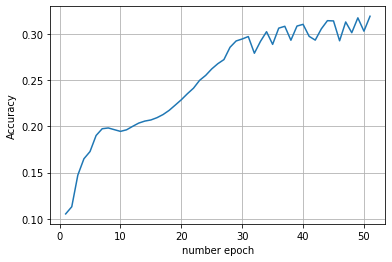

In [26]:
plt.plot(np.arange(1,len(MyNetwork.accuracy_graph_epoch)+1), MyNetwork.accuracy_graph_epoch)
plt.ylabel('Accuracy')
plt.xlabel("number epoch")
plt.grid(True)
plt.show()

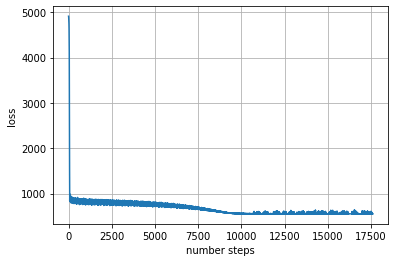

In [27]:
plt.plot(np.arange(1,len(MyNetwork.loss_graph)+1), MyNetwork.loss_graph)
plt.ylabel('loss')
plt.xlabel("number steps")
plt.grid(True)
plt.show()